In [54]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchtext.data import Field,BucketIterator,TabularDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split

In [168]:
data = pd.read_csv('children_stories.csv',encoding='latin-1',usecols=['cats','desc'])

In [169]:
#移除空標籤
data = data.query('cats != "Age "')

In [170]:
data.cats.value_counts()

Age 3+          32
Age 9+          32
Age 7+          27
Age 8+          26
Age 10+         26
Age 6+          21
Age 2-9         20
Age 4+          20
Age 11+         19
Age 5+          17
Age 0-4         16
Age 0+          13
Age 12+         12
Age 2+          12
Age 0-3         11
Age 2-6         10
Age 3-6          9
Age 2-5          9
Age 0-5          8
Age 3-5          7
Age 1-3          6
Age 1-5          5
Age 3-7          5
Age 1-4          4
Age 8-12         4
Age 7-11         4
Age 5-8          3
Age 4-8          3
Age 9-11         3
Age 6-11         3
Age 13+          3
Age 4-6          3
Age 9-12         2
Age 4-7          2
Age 0-2          2
Age 5-9          2
Age 6-8          2
Age 1+           2
Age 7-9          2
Age 9-13         2
Age 7-10         2
Age 0-6          1
Age 3-4          1
Age 9-14         1
Age 6months+     1
Age 2-4          1
Age 4-11         1
Age 2-7          1
Age 11-15        1
Age 10-14        1
Age 1-2          1
Age 1-6          1
Age 4-5     

In [171]:
train,test = train_test_split(data)

In [172]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

In [173]:
TEXT = Field(lower=True, include_lengths=True,fix_length=1000, batch_first=True)
LABEL = Field(sequential=False)
fields = {'desc': ('text',TEXT),'cats': ('label',LABEL)}

In [174]:
train, test = TabularDataset.splits(path='./',
                                    train='train.csv',
                                    test='test.csv',
                                    format='csv',
                                    fields=fields)

In [175]:
TEXT.build_vocab(train)
LABEL.build_vocab(train)

In [176]:
train_iter, test_iter = BucketIterator.splits(
    (train, test), batch_size=32, device=0,sort=False)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [185]:
class TextCNN(nn.Module):
    
    def __init__(self, embed_dim = 128, kernel_size=[2,3,4]):
        super(TextCNN,self).__init__()
        self.kernel_size = kernel_size
        
        self.embed = nn.Embedding(len(TEXT.vocab),embed_dim)
        self.cnn = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1,32,(kernel,embed_dim)),
                nn.LeakyReLU()
            )
            for kernel in kernel_size
        ])
        self.fc = nn.Linear(32*len(kernel_size),len(LABEL.vocab))
    
    def forward(self,x):
        tmp = self.embed(x).unsqueeze(1) # Batch_size, channel_number, Seq_len, embed_dim
        tmp = [c(tmp).squeeze(3) for c in self.cnn] # Batch_size, filter_number, Width
        tmp = [F.max_pool1d(t,t.size(2)).squeeze(2) for t in tmp] # Batch_size, filter_number
        tmp = torch.cat(tmp,1)
        tmp = self.fc(tmp)
        
        return tmp

In [199]:
model = TextCNN().cuda()

In [187]:
## 測試 forward
for i in train_iter:
    text = i.text[0].cuda()
    output = model(text)
    print(output.shape)
    break

torch.Size([32, 54])


In [200]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())

In [201]:
epoches = 20

In [202]:
model.train()
training_loss = []
for e in range(epoches):
    running_loss = 0.0
    for data in tqdm(train_iter):
        text = data.text[0].cuda()
        label = data.label.cuda()-1
        
        output = model(text)
        
        optim.zero_grad()
        loss = criterion(output,label)
        loss.backward(retain_graph=True)
        optim.step()
        
        running_loss += loss.item()
    training_loss.append(running_loss/len(train))
    print(f'epoch {e+1} : {running_loss/len(train)}')

 36%|██████████████████████████████▏                                                    | 4/11 [00:00<00:00, 29.63it/s]

epoch 1 : 0.14048012469045099


 27%|██████████████████████▋                                                            | 3/11 [00:00<00:00, 25.87it/s]

epoch 2 : 0.11544962464091933


 27%|██████████████████████▋                                                            | 3/11 [00:00<00:00, 25.42it/s]

epoch 3 : 0.10314239668326214


 36%|██████████████████████████████▏                                                    | 4/11 [00:00<00:00, 30.31it/s]

epoch 4 : 0.10861446998572424


 27%|██████████████████████▋                                                            | 3/11 [00:00<00:00, 25.22it/s]

epoch 5 : 0.09473635474469431


 27%|██████████████████████▋                                                            | 3/11 [00:00<00:00, 25.00it/s]

epoch 6 : 0.09293957959825748


 36%|██████████████████████████████▏                                                    | 4/11 [00:00<00:00, 30.30it/s]

epoch 7 : 0.08960937933758412


 27%|██████████████████████▋                                                            | 3/11 [00:00<00:00, 24.99it/s]

epoch 8 : 0.08313388987865032


 27%|██████████████████████▋                                                            | 3/11 [00:00<00:00, 24.59it/s]

epoch 9 : 0.07811949483330748


 36%|██████████████████████████████▏                                                    | 4/11 [00:00<00:00, 30.54it/s]

epoch 10 : 0.07550627271705698


 27%|██████████████████████▋                                                            | 3/11 [00:00<00:00, 25.00it/s]

epoch 11 : 0.07522158979255462


 27%|██████████████████████▋                                                            | 3/11 [00:00<00:00, 25.64it/s]

epoch 12 : 0.0690631636206606


 27%|██████████████████████▋                                                            | 3/11 [00:00<00:00, 24.80it/s]

epoch 13 : 0.06598995927709657


 27%|██████████████████████▋                                                            | 3/11 [00:00<00:00, 25.87it/s]

epoch 14 : 0.06050241661963062


 27%|██████████████████████▋                                                            | 3/11 [00:00<00:00, 24.39it/s]

epoch 15 : 0.055809328860582964


 27%|██████████████████████▋                                                            | 3/11 [00:00<00:00, 25.43it/s]

epoch 16 : 0.05437311056618378


 36%|██████████████████████████████▏                                                    | 4/11 [00:00<00:00, 30.31it/s]

epoch 17 : 0.04807203989533992


 36%|██████████████████████████████▏                                                    | 4/11 [00:00<00:00, 30.77it/s]

epoch 18 : 0.04332394614769291


 27%|██████████████████████▋                                                            | 3/11 [00:00<00:00, 25.64it/s]

epoch 19 : 0.03967355270623418


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 27.37it/s]

epoch 20 : 0.036155263582865395


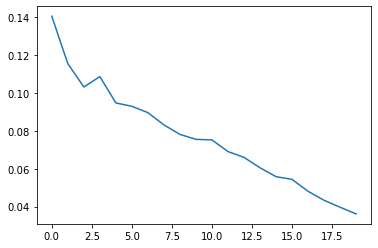

In [203]:
plt.plot(training_loss)

In [206]:
model.eval()
with torch.no_grad():
    running_hit = 0.0
    for data in tqdm(train_iter):
        text = data.text[0].cuda()
        label = (data.label.cuda()-1)
        
        output = model(text)
        
        pred = output.argmax(dim=1)
        pred = torch.sum(pred == label)
        running_hit += pred.item()
    print(running_hit/len(train))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 99.50it/s]

0.8847352024922118


In [207]:
model.eval()
with torch.no_grad():
    running_hit = 0.0
    for data in tqdm(test_iter):
        text = data.text[0].cuda()
        label = (data.label.cuda()-1)
        
        output = model(text)
        
        pred = output.argmax(dim=1)
        pred = torch.sum(pred == label)
        running_hit += pred.item()
    print(running_hit/len(test))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 76.93it/s]

0.08411214953271028


In [208]:
torch.save(model.state_dict(),'textcnn.pth')